In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


import joblib
from imblearn.over_sampling import SMOTE
from joblib import dump, load
import os
from tkinter import Tk, Entry, Label, Button, Frame, Toplevel

### Read Data

In [51]:
df = pd.read_csv("/kaggle/input/crime-prediction-in-chicago-in-2022/Crime Prediction in Chicago_Dataset.csv")
df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12592454,JF113025,1/14/2022 15:55,067XX S MORGAN ST,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,True,...,16.0,68,26,1170805.0,1860170.0,2022,9/14/2023 15:41,41.771782,-87.649437,"(41.771782439, -87.649436929)"
1,12785595,JF346553,8/5/2022 21:00,072XX S UNIVERSITY AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,True,False,...,5.0,69,17,1185135.0,1857211.0,2022,9/14/2023 15:41,41.763338,-87.597001,"(41.763337967, -87.597001131)"
2,12808281,JF373517,8/14/2022 14:00,055XX W ARDMORE AVE,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,39.0,11,17,1138383.0,1937953.0,2022,9/14/2023 15:41,41.985875,-87.766404,"(41.985875279, -87.766403857)"
3,12888104,JF469015,11/10/2022 3:47,072XX S MAY ST,1477,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,STREET,False,False,...,17.0,68,15,1169903.0,1856822.0,2022,9/14/2023 15:41,41.762615,-87.652840,"(41.76261474, -87.652840463)"
4,13209277,JG422539,8/15/2022 9:00,0000X W JACKSON BLVD,810,THEFT,OVER $500,COMMERCIAL / BUSINESS OFFICE,False,False,...,4.0,32,6,NaN,NaN,2022,9/14/2023 15:43,NaN,NaN,NaN


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239558 entries, 0 to 239557
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    239558 non-null  int64  
 1   Case Number           239558 non-null  object 
 2   Date                  239558 non-null  object 
 3   Block                 239558 non-null  object 
 4   IUCR                  239558 non-null  object 
 5   Primary Type          239558 non-null  object 
 6   Description           239558 non-null  object 
 7   Location Description  238593 non-null  object 
 8   Arrest                239558 non-null  bool   
 9   Domestic              239558 non-null  bool   
 10  Beat                  239558 non-null  int64  
 11  District              239558 non-null  int64  
 12  Ward                  239548 non-null  float64
 13  Community Area        239558 non-null  int64  
 14  FBI Code              239558 non-null  object 
 15  

### Handling Date Formats

In [53]:
df['Date'] = df['Date'].str.replace('/', '-')
df['Date'].head()

0    1-14-2022 15:55
1     8-5-2022 21:00
2    8-14-2022 14:00
3    11-10-2022 3:47
4     8-15-2022 9:00
Name: Date, dtype: object

In [54]:
df['Updated On'] = df['Updated On'].str.replace('/', '-')
df['Updated On'].head()

0    9-14-2023 15:41
1    9-14-2023 15:41
2    9-14-2023 15:41
3    9-14-2023 15:41
4    9-14-2023 15:43
Name: Updated On, dtype: object

### Split Data

In [55]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day of Week'] = df['Date'].dt.dayofweek


### Removing Nulls 

In [56]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)


df.dropna(inplace=True)

Missing Values:
 ID                         0
Case Number                0
Date                       0
Block                      0
IUCR                       0
Primary Type               0
Description                0
Location Description     965
Arrest                     0
Domestic                   0
Beat                       0
District                   0
Ward                      10
Community Area             0
FBI Code                   0
X Coordinate            4667
Y Coordinate            4667
Year                       0
Updated On                 0
Latitude                4667
Longitude               4667
Location                4667
Month                      0
Day                        0
Day of Week                0
dtype: int64


In [57]:
print("\nMissing Values After Handling:\n", df.isnull().sum())


Missing Values After Handling:
 ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
Month                   0
Day                     0
Day of Week             0
dtype: int64


## UNI-Variate Analysis

### Date Column

In [58]:
df['Date'].value_counts()

Date
2022-01-01 00:00:00    93
2022-08-01 00:00:00    84
2022-07-01 00:00:00    73
2022-06-01 00:00:00    72
2022-03-01 00:00:00    68
                       ..
2022-06-01 00:38:00     1
2022-05-27 13:15:00     1
2022-07-21 09:01:00     1
2022-05-24 17:28:00     1
2022-06-23 02:25:00     1
Name: count, Length: 110874, dtype: int64

### Block Column

In [59]:
df['Block'].value_counts()

Block
001XX N STATE ST       592
0000X W TERMINAL ST    555
100XX W OHARE ST       315
003XX E RANDOLPH ST    300
0000X N STATE ST       260
                      ... 
087XX W HIGGINS RD       1
060XX S DREXEL AVE       1
092XX S HOYNE AVE        1
052XX W BELDEN AVE       1
000XX E 100TH PL         1
Name: count, Length: 27598, dtype: int64

### IUCR Column

In [60]:
df['IUCR'].value_counts()

IUCR
810     19672
486     18633
820     18533
910     17087
1320    14103
        ...  
1850        1
142A        1
2110        1
2019        1
5009        1
Name: count, Length: 303, dtype: int64

### Primary Type

In [61]:
df['Primary Type'].value_counts()

Primary Type
THEFT                                53621
BATTERY                              40800
CRIMINAL DAMAGE                      27028
MOTOR VEHICLE THEFT                  21386
ASSAULT                              20737
DECEPTIVE PRACTICE                   14737
OTHER OFFENSE                        14369
ROBBERY                               8952
WEAPONS VIOLATION                     8709
BURGLARY                              7563
CRIMINAL TRESPASS                     4202
NARCOTICS                             4036
OFFENSE INVOLVING CHILDREN            1764
CRIMINAL SEXUAL ASSAULT               1485
SEX OFFENSE                           1138
HOMICIDE                               732
PUBLIC PEACE VIOLATION                 706
STALKING                               429
ARSON                                  421
INTERFERENCE WITH PUBLIC OFFICER       392
PROSTITUTION                           283
LIQUOR LAW VIOLATION                   203
INTIMIDATION                           17

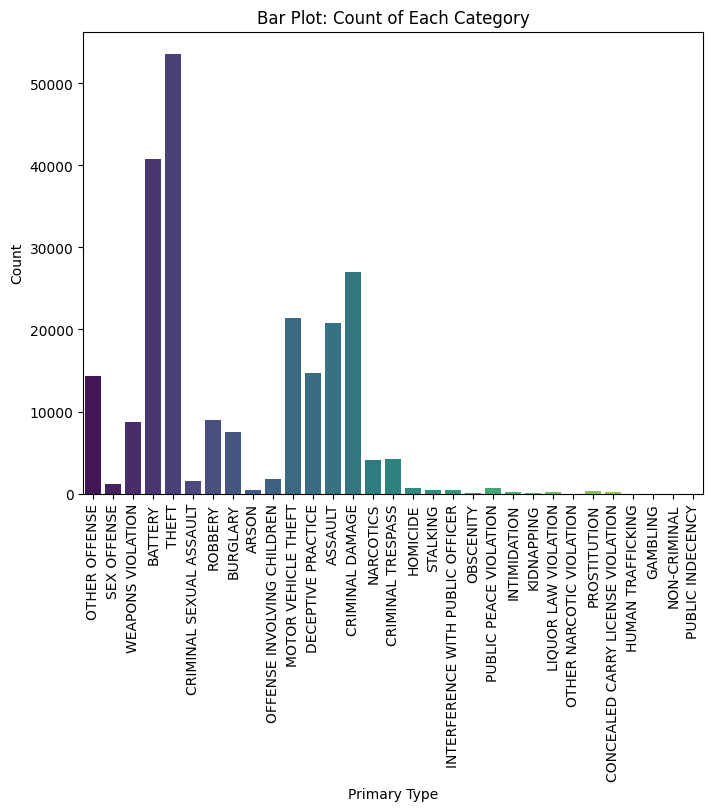

In [62]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Primary Type', palette='viridis') 
plt.title('Bar Plot: Count of Each Category')
plt.xlabel('Primary Type')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

### Description Column

In [63]:
df['Description'].value_counts()

Description
SIMPLE                                        27086
OVER $500                                     19672
DOMESTIC BATTERY SIMPLE                       18633
$500 AND UNDER                                18533
AUTOMOBILE                                    17087
                                              ...  
CANNABIS PLANT                                    1
UNLAWFUL SALE - HANDGUN                           1
POSSESS - HYPODERMIC NEEDLE                       1
MANUFACTURE / DELIVER - HEROIN (BLACK TAR)        1
VIOLATION OF SMOKING BAN                          1
Name: count, Length: 283, dtype: int64

### Location Description Column

In [64]:
df['Location Description'].value_counts()

Location Description
STREET                                    67239
APARTMENT                                 44848
RESIDENCE                                 29750
SIDEWALK                                  11895
PARKING LOT / GARAGE (NON RESIDENTIAL)     9240
                                          ...  
CHA GROUNDS                                   1
BANQUET HALL                                  1
FARM                                          1
TAVERN                                        1
STAIRWELL                                     1
Name: count, Length: 135, dtype: int64

### Arrest Column

In [65]:
df['Arrest'].value_counts()

Arrest
False    207001
True      27237
Name: count, dtype: int64

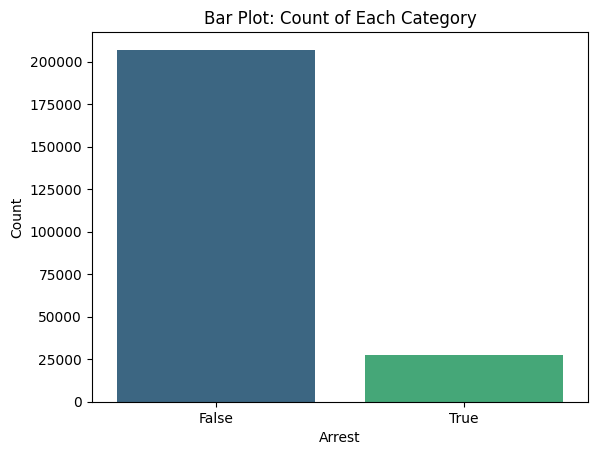

In [66]:
sns.countplot(data=df, x='Arrest', palette='viridis') 
plt.title('Bar Plot: Count of Each Category')
plt.xlabel('Arrest')
plt.ylabel('Count')
plt.show()

### Domestic Column

In [67]:
df['Domestic'].value_counts()

Domestic
False    189699
True      44539
Name: count, dtype: int64

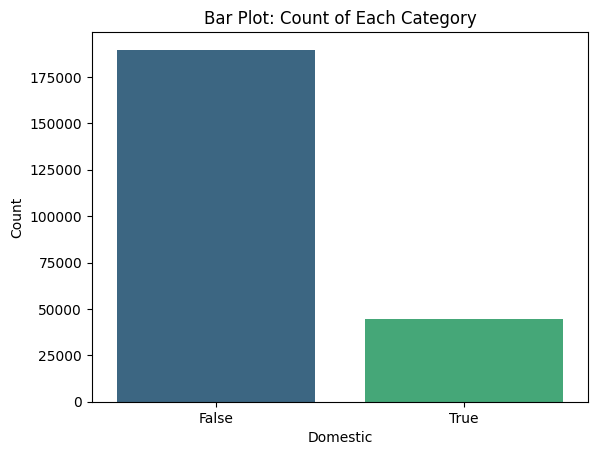

In [68]:
sns.countplot(data=df, x='Domestic', palette='viridis') 
plt.title('Bar Plot: Count of Each Category')
plt.xlabel('Domestic')
plt.ylabel('Count')
plt.show()

### Beat Column

In [69]:
df['Beat'].describe()

count    234238.000000
mean       1151.923582
std         707.902204
min         111.000000
25%         533.000000
50%        1032.000000
75%        1724.000000
max        2535.000000
Name: Beat, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


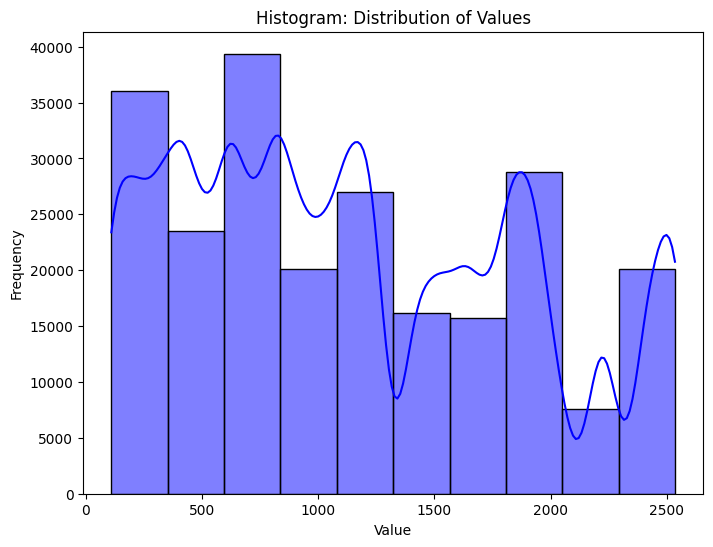

In [70]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Beat', bins=10, kde=True, color='blue')
plt.title('Histogram: Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### District Column

In [71]:
df['District'].describe()

count    234238.000000
mean         11.289859
std           7.075689
min           1.000000
25%           5.000000
50%          10.000000
75%          17.000000
max          31.000000
Name: District, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


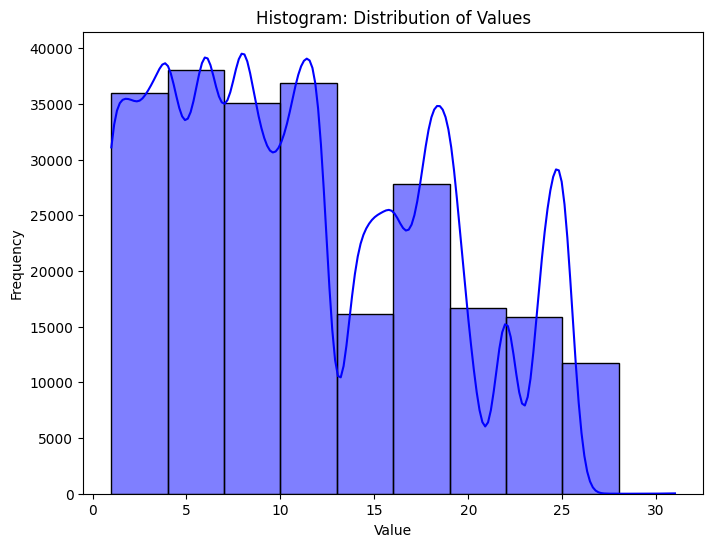

In [72]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='District', bins=10, kde=True, color='blue')
plt.title('Histogram: Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Ward Column

In [73]:
df['Ward'].describe()

count    234238.000000
mean         23.319333
std          14.192480
min           1.000000
25%           9.000000
50%          24.000000
75%          35.000000
max          50.000000
Name: Ward, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


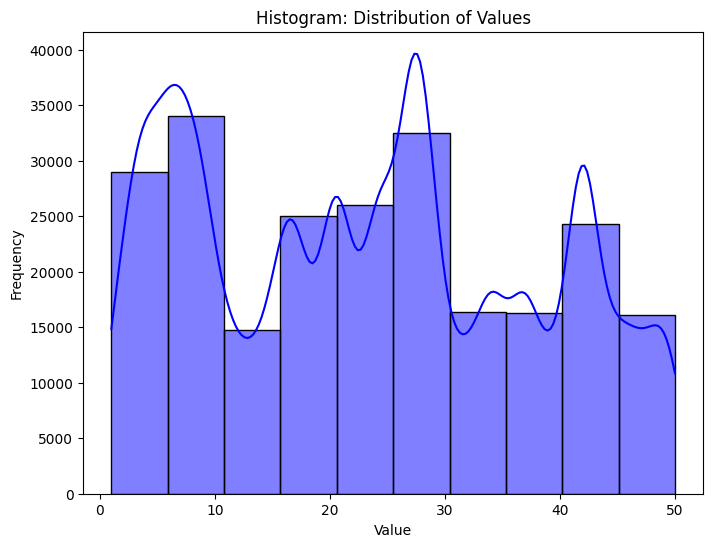

In [74]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Ward', bins=10, kde=True, color='blue')
plt.title('Histogram: Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Community Area Column

In [75]:
df['Community Area'].describe()

count    234238.000000
mean         36.358123
std          21.536407
min           1.000000
25%          22.000000
50%          32.000000
75%          53.000000
max          77.000000
Name: Community Area, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


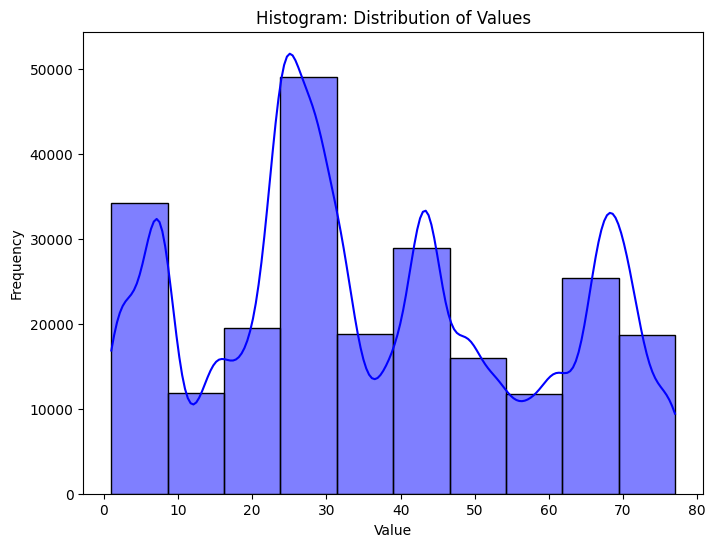

In [76]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Community Area', bins=10, kde=True, color='blue')  # KDE adds a smooth density curve
plt.title('Histogram: Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### FBI Code Column

In [77]:
df['FBI Code'].value_counts()

FBI Code
6      53621
08B    33823
14     27028
7      21386
08A    17457
26     15398
11     12213
3       8952
15      8890
5       7563
04B     7473
04A     7268
18      4039
10      2427
2       1680
17      1538
24      1084
01A      725
20       652
9        421
16       283
22       203
13        75
12        22
19        10
01B        7
Name: count, dtype: int64

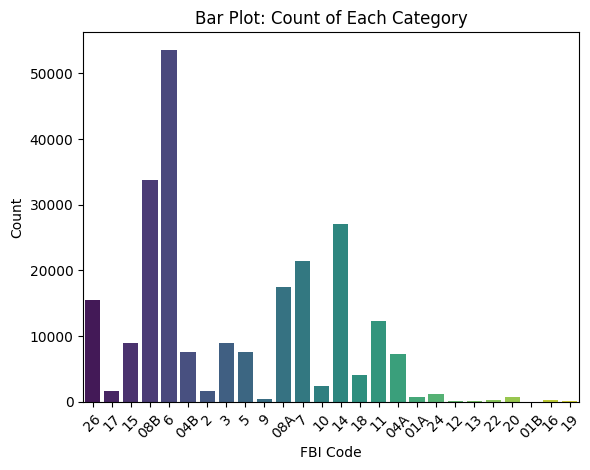

In [78]:
sns.countplot(data=df, x='FBI Code', palette='viridis') 
plt.title('Bar Plot: Count of Each Category')
plt.xlabel('FBI Code')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

### X Coordinate Column

In [79]:
df['X Coordinate'].describe()

count    2.342380e+05
mean     1.165383e+06
std      1.679707e+04
min      0.000000e+00
25%      1.153939e+06
50%      1.167257e+06
75%      1.176863e+06
max      1.205119e+06
Name: X Coordinate, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


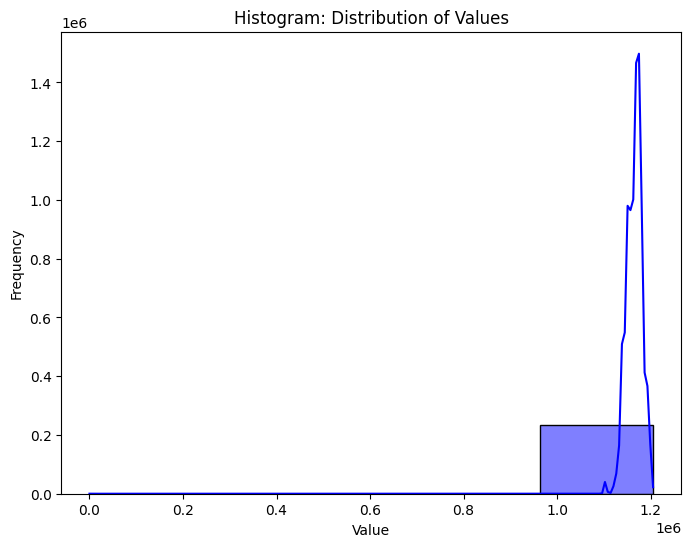

In [80]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='X Coordinate', bins=5, kde=True, color='blue')
plt.title('Histogram: Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Y Coordinate Column

In [81]:
df['Y Coordinate'].describe()

count    2.342380e+05
mean     1.887002e+06
std      3.229316e+04
min      0.000000e+00
25%      1.859276e+06
50%      1.893253e+06
75%      1.910013e+06
max      1.951493e+06
Name: Y Coordinate, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


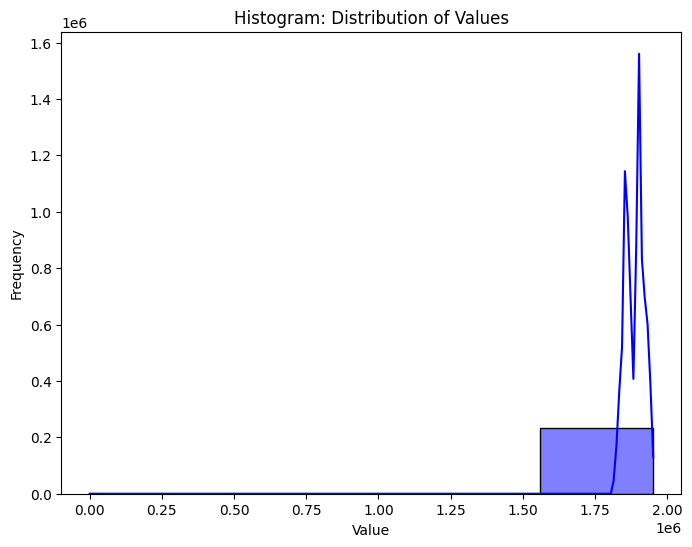

In [82]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Y Coordinate', bins=5, kde=True, color='blue')
plt.title('Histogram: Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Year Column

In [83]:
df['Year'].describe()

count    234238.0
mean       2022.0
std           0.0
min        2022.0
25%        2022.0
50%        2022.0
75%        2022.0
max        2022.0
Name: Year, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


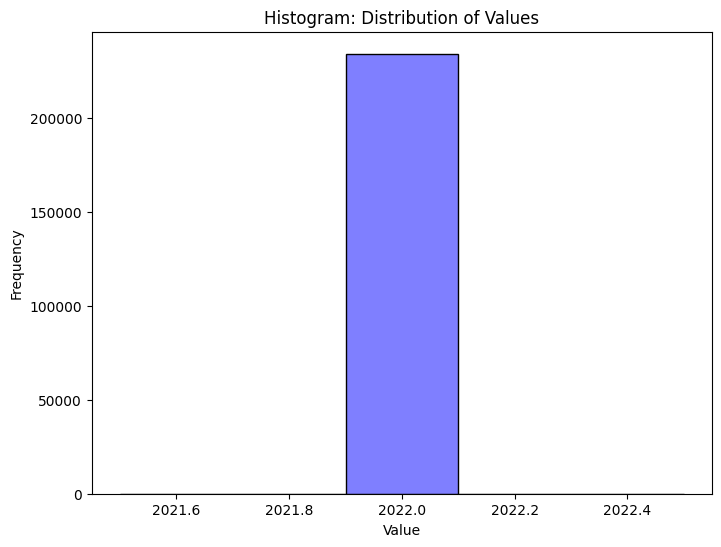

In [84]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Year', bins=5, kde=True, color='blue')
plt.title('Histogram: Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

- It is one bar only because of the data is all in 2022

### Updated On Column

In [85]:
df['Updated On'].value_counts()

Updated On
1-3-2023 15:40      226582
11-15-2023 15:41      1994
1-5-2023 15:42         535
1-6-2023 15:40         533
1-4-2023 15:41         520
                     ...  
8-20-2024 15:40          1
8-31-2024 15:40          1
8-19-2024 15:40          1
8-16-2024 15:40          1
12-29-2022 15:40         1
Name: count, Length: 706, dtype: int64

### Latitude Column

In [86]:
df['Latitude'].describe()

count    234238.000000
mean         41.845512
std           0.088826
min          36.619446
25%          41.769102
50%          41.862894
75%          41.908864
max          42.022548
Name: Latitude, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


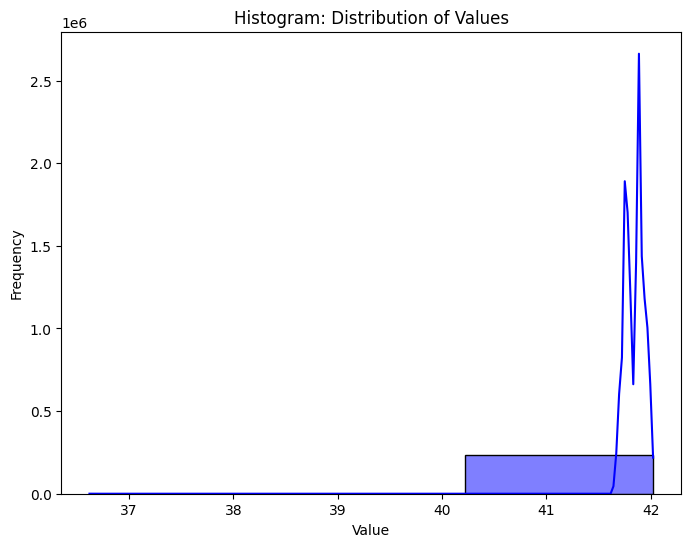

In [87]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Latitude', bins=3, kde=True, color='blue') 
plt.title('Histogram: Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Longitude Column

In [88]:
df['Longitude'].describe()

count    234238.000000
mean        -87.668591
std           0.061021
min         -91.686566
25%         -87.710164
50%         -87.661457
75%         -87.626387
max         -87.524532
Name: Longitude, dtype: float64

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


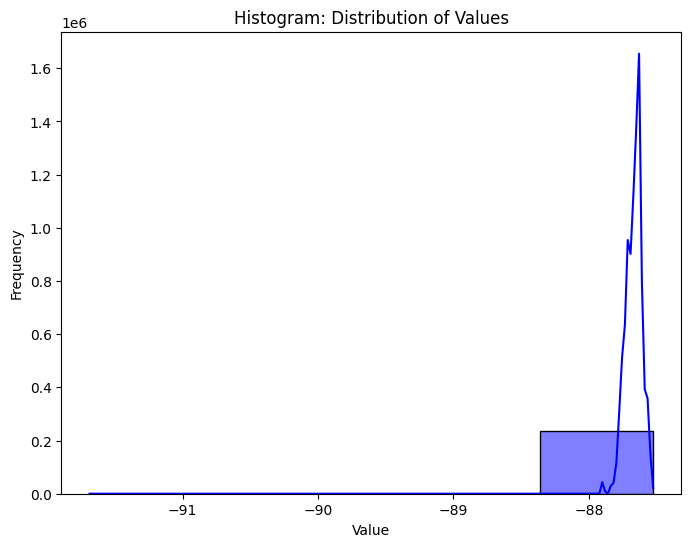

In [89]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Longitude', bins=5, kde=True, color='blue') 
plt.title('Histogram: Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### Location Column

In [90]:
df['Location'].value_counts()

Location
(41.976290414, -87.905227221)    315
(41.883500187, -87.627876698)    285
(41.884335468, -87.619164088)    252
(41.788987036, -87.74147999)     225
(41.976762981, -87.900983721)    196
                                ... 
(41.895787423, -87.76241906)       1
(41.737742701, -87.74096146)       1
(41.941416449, -87.723587352)      1
(41.941947831, -87.661456632)      1
(41.682299252, -87.620652127)      1
Name: count, Length: 118057, dtype: int64

### Month Column

In [91]:
df['Month'].value_counts()

Month
10    22631
7     21839
8     21837
9     21807
11    20403
6     20402
5     19839
12    19751
3     17888
4     17701
1     15261
2     14879
Name: count, dtype: int64

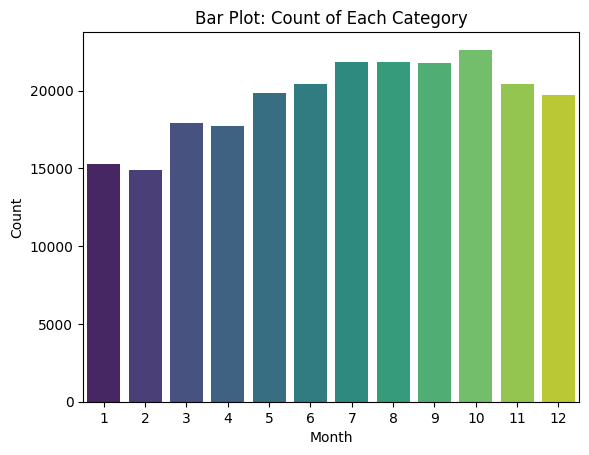

In [92]:
sns.countplot(data=df, x='Month', palette='viridis') 
plt.title('Bar Plot: Count of Each Category')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

### Day Column

In [93]:
df['Day'].value_counts()

Day
1     8753
12    7900
10    7808
22    7790
18    7761
16    7726
11    7722
20    7714
19    7714
21    7709
4     7701
28    7685
6     7660
15    7634
2     7628
23    7624
17    7616
27    7607
3     7603
26    7596
14    7587
7     7527
5     7527
24    7494
30    7468
8     7467
13    7455
29    7391
25    7342
9     7332
31    4697
Name: count, dtype: int64

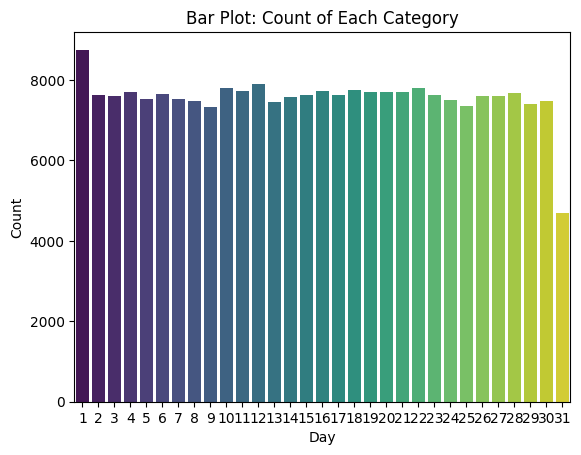

In [94]:
sns.countplot(data=df, x='Day', palette='viridis') 
plt.title('Bar Plot: Count of Each Category')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

### Day of Week Column

In [95]:
df['Day of Week'].value_counts()

Day of Week
4    34612
5    34518
2    33221
0    33197
1    33083
3    32974
6    32633
Name: count, dtype: int64

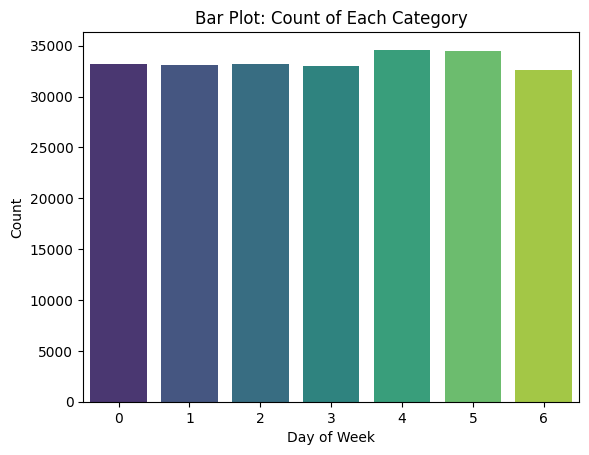

In [96]:
sns.countplot(data=df, x='Day of Week', palette='viridis') 
plt.title('Bar Plot: Count of Each Category')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.show()

## PreProcessing

### Remove Uneeded Data

In [97]:
df = df[['Year', 'Month', 'Day', 'Day of Week', 'Latitude', 'Longitude', 'Domestic', 'Primary Type', 'Location Description', 'Arrest','Description']]

### Encoding

In [98]:
label_encoders = {}
for column in ['Domestic', 'Primary Type', 'Location Description','Description']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Save label encoders using joblib
joblib.dump(label_encoders, 'label_encoders.joblib')

df.head()


,Year,Month,Day,Day of Week,Latitude,Longitude,Domestic,Primary Type,Location Description,Arrest,Description
0,2022,1,14,4,41.771782,-87.649437,1,22,102,False,129
1,2022,8,5,4,41.763338,-87.597001,0,27,17,True,227
2,2022,8,14,6,41.985875,-87.766404,0,27,102,False,13
3,2022,11,10,3,41.762615,-87.652840,0,30,119,False,214
5,2022,2,19,5,41.900506,-87.699285,1,2,77,True,103


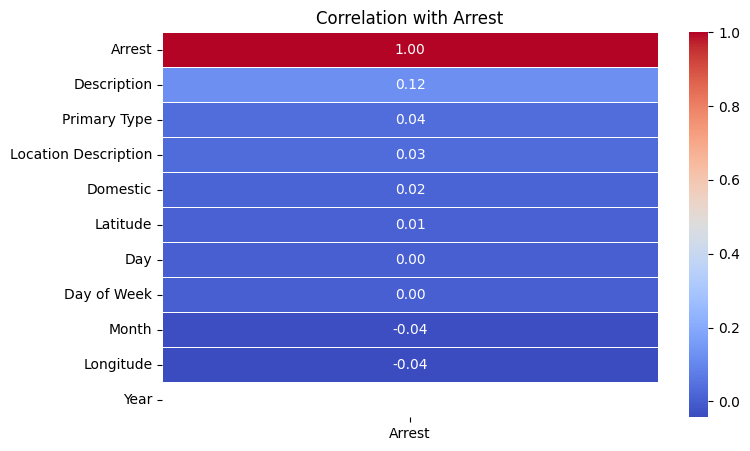

In [99]:
correlation_matrix = df.corr(numeric_only=True)
correlation_arrest = correlation_matrix['Arrest'].sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_arrest.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation with Arrest')
plt.show()

<Axes: >

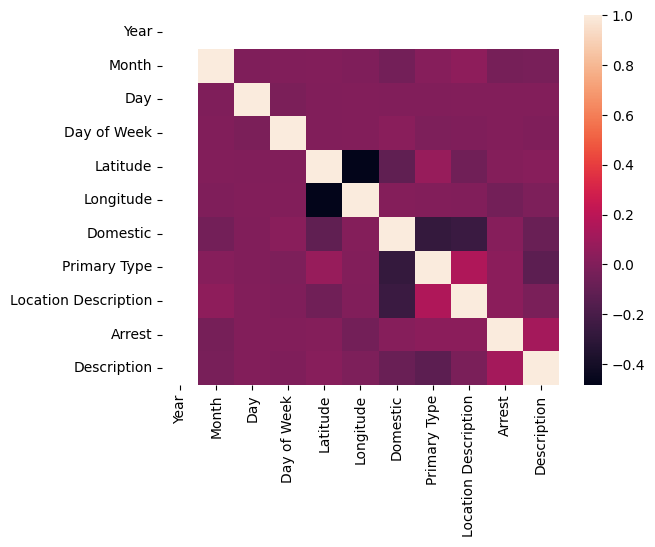

In [100]:
sns.heatmap(df.corr())

### Select Features in X and Y

In [101]:
X = df.drop(columns='Arrest')
y = df['Arrest']

### Splitting Data

In [102]:
smote=SMOTE(sampling_strategy=0.60,random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

In [103]:
y_smote.value_counts()

Arrest
False    207001
True     124200
Name: count, dtype: int64

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

### Scalling

In [105]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

## Machine Learning

In [106]:
models = {
    'Logistic Regression': LogisticRegression(C=1.0),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100),
    'CatBoost': CatBoostClassifier(verbose=0),
    'Random Forest': RandomForestClassifier(n_estimators=100)
    
    # ,'SVM': SVC(probability=True),
    # 'Decision Tree': DecisionTreeClassifier(min_samples_split=2),
    # 'KNN': KNeighborsClassifier(n_neighbors=5)
}

In [107]:
best_model = None
best_score = 0
best_model_name = None
model_metrics = []  

# Train and evaluate each model
for name, model in models.items():
    print(f'\nTraining {name}...')
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)  
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # Store metrics in a list
    model_metrics.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'ROC-AUC': roc_auc if roc_auc is not None else 'N/A'
    })

    print(f'{name} Performance:')
    print(f'Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1 Score: {f1:.2f}, ROC-AUC: {roc_auc}')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

    # Select the best model
    if roc_auc is not None and roc_auc > best_score:
        best_model = model
        best_model_name = name
        best_score = roc_auc

# Save the best model
if best_model:
    joblib.dump(best_model, 'best_model.joblib')
    print(f'\nBest model saved: {best_model_name} with ROC-AUC: {best_score:.2f}')
else:
    print('No best model found.')

# Display all models with their metrics
metrics_df = pd.DataFrame(model_metrics)
print('\nModel Performance Summary:')
print(metrics_df)

# Display the best model
if best_model_name:
    print(f'\nThe best model is: {best_model_name}')
    print(f'ROC-AUC Score: {best_score:.2f}')


Training Logistic Regression...
Logistic Regression Performance:
Accuracy: 0.66, Precision: 0.61, Recall: 0.23, F1 Score: 0.34, ROC-AUC: 0.6356288054957249
Confusion Matrix:
[[37711  3690]
 [19020  5820]]
Classification Report:
              precision    recall  f1-score   support

       False       0.66      0.91      0.77     41401
        True       0.61      0.23      0.34     24840

    accuracy                           0.66     66241
   macro avg       0.64      0.57      0.55     66241
weighted avg       0.64      0.66      0.61     66241


Training XGBoost...
XGBoost Performance:
Accuracy: 0.85, Precision: 0.86, Recall: 0.73, F1 Score: 0.79, ROC-AUC: 0.9258190055542933
Confusion Matrix:
[[38495  2906]
 [ 6720 18120]]
Classification Report:
              precision    recall  f1-score   support

       False       0.85      0.93      0.89     41401
        True       0.86      0.73      0.79     24840

    accuracy                           0.85     66241
   macro avg       0.

## GUI

In [108]:
def create_window():
    window = Tk()
    window.title("Crime Detection App")
    window.geometry("600x680")
    window.configure(bg="#1E1E2E")

    def open_output_window():
        if not validate_entries():
            return
        input_data = collect_and_save_data()
        predicted_class, probability = predict_crime(input_data)
        create_output_window(window, predicted_class, probability)

    def validate_entries():
        for label_text, entry in entries.items():
            if entry.get() == "":
                show_error_message("Please enter full data.")
                return False
        return True

    def show_error_message(message):
        error_label.config(text=message)
        error_label.place(x=50, y=50, width=500, height=30)

    def collect_and_save_data():
        input_data = {}
        for label_text, entry in entries.items():
            input_data[label_text] = entry.get()
        return input_data

    header_frame = Frame(window, bg="#5C0B78", bd=5, relief="ridge")
    header_frame.place(x=50, y=10, width=500, height=60)
    header = Label(header_frame, text="Crime Detection App", bg="#5C0B78", fg="#FFFFFF", font=("Helvetica", 20, "bold"))
    header.pack()

    input_fields = [
        ("Year", 80), ("Month", 130), ("Day", 180),
        ("Day of Week", 230), ("Latitude", 280),
        ("Longitude", 330), ("Domestic", 380),
        ("Primary Type", 430), ("Location Description", 480),( "Description", 530)
    ]
    entries = {}
    for label_text, y_position in input_fields:
        frame = Frame(window, bg="#2B2B3D", bd=5, relief="ridge")
        frame.place(x=50, y=y_position - 10, width=500, height=50)
        label = Label(frame, text=label_text, bg="#2B2B3D", fg="#FFFFFF", font=("Helvetica", 12))
        label.place(x=10, y=5)
        entry_frame = Frame(frame, bg="#D9D9D9", bd=2, relief="ridge")
        entry_frame.place(x=200, y=6, width=280, height=23)
        entry = Entry(entry_frame, bd=0, bg="#FFFFFF", fg="#000716")
        entry.pack(fill='both', expand=True)
        entries[label_text] = entry

    error_label = Label(window, text="", bg="#FF4C4C", fg="#FFFFFF", font=("Helvetica", 12), anchor="center")

    submit_button_frame = Frame(window, bg="#5C0B78", bd=5, relief="ridge")
    submit_button_frame.place(x=250, y=610, width=100, height=40)
    submit_button = Button(submit_button_frame, text="Submit", bg="#5C0B78", fg="#FFFFFF", font=("Helvetica", 12), command=open_output_window)
    submit_button.pack(fill='both', expand=True)

    window.mainloop()

def predict_crime(input_data):
    try:
        for column, encoder in label_encoders.items():
            if column in input_data:
                input_data[column] = encoder.transform([input_data[column]])[0]
        input_df = pd.DataFrame([input_data])
        input_scaled = scaler.transform(input_df)
        predicted_class = best_model.predict(input_scaled)[0]
        probability = best_model.predict_proba(input_scaled)[:, 1][0] if hasattr(best_model, 'predict_proba') else None
        return predicted_class, probability
    except Exception as e:
        print(f"Prediction error: {e}")
        return None, None

def create_output_window(previous_window, predicted_class, probability):
    previous_window.withdraw()
    output_window = Toplevel()
    output_window.title("Crime Detection Output")
    output_window.geometry("600x600")
    output_window.configure(bg="#1E1E2E")

    def go_back():
        output_window.destroy()
        previous_window.deiconify()

    header_frame = Frame(output_window, bg="#5C0B78", bd=5, relief="ridge")
    header_frame.place(x=50, y=10, width=500, height=60)
    header = Label(header_frame, text="Crime Detection Output", bg="#5C0B78", fg="#FFFFFF", font=("Helvetica", 20, "bold"))
    header.pack()

    output_labels = [
        f"Predicted Arrest: {predicted_class}",
        f"Probability of Arrest: {probability:.2f}" if probability is not None else "Probability of Arrest: N/A"
    ]
    for i, text in enumerate(output_labels):
        frame = Frame(output_window, bg="#2B2B3D", bd=5, relief="ridge")
        frame.place(x=50, y=100 + i * 60, width=500, height=40)
        label = Label(frame, text=text, bg="#2B2B3D", fg="#FFFFFF", font=("Helvetica", 12))
        label.pack()

    back_button_frame = Frame(output_window, bg="#5C0B78", bd=5, relief="ridge")
    back_button_frame.place(x=250, y=340, width=100, height=40)
    back_button = Button(back_button_frame, text="Back", bg="#5C0B78", fg="#FFFFFF", font=("Helvetica", 12), command=go_back)
    back_button.pack(fill='both', expand=True)

    output_window.mainloop()

create_window()

TclError: no display name and no $DISPLAY environment variable